In [1]:
import os
import numpy as np
import astropy.units as u
import astropy
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source" # Select early Data Release 3
%matplotlib inline

In [55]:
def load_img(file):
    """
    加载图像，dat和fits均支持，不过仅支持CxHxW
    :param filename: 传入文件名，应当为CHW
    :return: 返回CHW的ndarray
    """
    if ".fits" in file:
        with fits.open(file) as hdul:
            return hdul[0].data.astype(np.float32)
    else:
        raise TypeError

def chw2hwc(img):
    ch1, ch2, ch3 = img[0], img[1], img[2]
    h, w = ch1.shape
    return np.concatenate((ch1.reshape(h, w, 1), ch2.reshape(h, w, 1), ch3.reshape(h, w, 1)), axis=2)

def hwc2chw(img):
    ch1, ch2, ch3 = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    return np.array((ch1, ch2, ch3))

def write2fits(data: np.ndarray, filename: str):
    """
    将ndarray保存成fits文件
    :param data: 待保存数据
    :param filename: 保存文件名
    :return:
    """
    if len(data.shape) == 2:
        hdu = fits.PrimaryHDU(data)
        hdulist = fits.HDUList([hdu])
        hdulist.writeto(filename)
        hdulist.close()
    elif data.shape[-1] == 3:
        g, r, z = data[:, :, 0], data[:, :, 1], data[:, :, 2]
        data = np.array((g, r, z))
        hdu = fits.PrimaryHDU(data)
        hdulist = fits.HDUList([hdu])
        hdulist.writeto(filename)
        hdulist.close()
    elif data.shape[0] == 3:
        hdu = fits.PrimaryHDU(data)
        hdulist = fits.HDUList([hdu])
        hdulist.writeto(filename)
        hdulist.close()
    else:
        raise RuntimeError

In [56]:
data_path = '/data/renhaoye/decals_2022/in_decals/augmentation_all/'
fits_path = '/data/renhaoye/decals_2022/in_decals/fits/'
data_list = os.listdir(fits_path)
i = 25226
ra, dec = data_list[i].split(".fits")[0].split("_")
ra, dec = float(ra), float(dec)

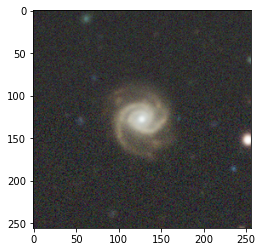

In [57]:
img = load_img(data_path + data_list[i])
plt.imshow(chw2hwc(img))
plt.show()

In [58]:
coord = astropy.coordinates.SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs')
resolution = u.Quantity(0.262, u.arcsec)
step = 1 * 0.262 * 3600
width = 256 * resolution
height = 256 * resolution
r = Gaia.query_object_async(coordinate=coord, width=width, height=height)
a = pd.DataFrame({'ra': r['ra'],'dec': r['dec'],'mag':r['phot_g_mean_mag']})

INFO: Query finished. [astroquery.utils.tap.core]


In [61]:
out  = np.zeros_like(img)
f = fits.open(fits_path + data_list[i])
wcs = WCS(f[0].header).sub(axes=2)
icrs_poi = []
for k in range(len(a)):
    icrs_poi.append([a.iloc[k].ra, a.iloc[k].dec])
pix_poi = wcs.all_world2pix(icrs_poi, 0).astype(int)
# pix_poi[:,0] = 256 - pix_poi[:,0]
# pix_poi[:,1] = 256 - pix_poi[:,1]
for j in range(pix_poi.shape[0]):
    out[:, pix_poi[j, 1]-3:pix_poi[j, 1]+3, pix_poi[j, 0]-3:pix_poi[j, 0]+3] = 1

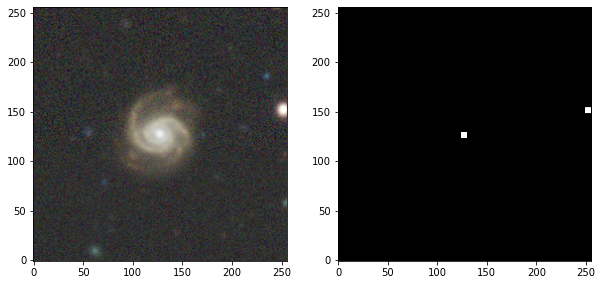

In [62]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(chw2hwc(img),origin="lower")
plt.subplot(122)
plt.imshow(chw2hwc(out),origin="lower")
plt.show()